## Fantasy Premier League Analysis

### Introduction

Inspired by the best rank in 9 FPL Seasons and motivated by an almost top 100K finish, this project seeks to explore insights that would land "Nene's Ballerz" a top 90K rank next season (24/25).  Ultimately, through this notebook we'll parse out data from an FPL API for managers (team) data and gameweek details from the previous season (23/24) in a bid to highlight decisions that were enabling and the ones that show areas of improvement. This is the first notebook in a series that will later include player analysis (for captain picks, squad vs bench selection), league (and specific minileague) analysis that will be actively maintained in the next season 2024-2025.

References

- https://gist.githubusercontent.com/James-Leslie/82abbb4c6808321b0cf8c801a84ff22e/raw/9b5a238a52159d8e856adcc2aa18a734b9178561/FPL-endpoints.csv
- https://www.reddit.com/r/FantasyPL/comments/f8t3bw/cheatsheet_of_all_current_fpl_endpoints/?rdt=50100

### Objective
Analyze last season's (2024-2025) team performance to highlight costly decisions in raking up best possible points.

### Approach
1. Parse out data from the FPL APIs
2. Piece together an individual manager's team, adding supporting game week events
3. Analyze hypotheses: 
    - The average team had a better week by week performance than the studied team
    - The chips usage did not yield significant returns in the given game week
    - Points left on bench were not significant for the respective game weeks
4. Summarize Findings

### Set Up

In [1]:
### Import necessary libraries
import os
import pandas as pd
import requests
import json
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

### Scraping FPL data from API

In [2]:
## base_url for all FPL API endpoints
base_url = 'https://fantasy.premierleague.com/api/'

## get data from the end-point
r = requests.get(base_url+'bootstrap-static/').json()

## inspect top level fields
pprint(r, indent=2,depth=1,compact=True)

{ 'element_stats': [...],
  'element_types': [...],
  'elements': [...],
  'events': [...],
  'game_settings': {...},
  'phases': [...],
  'teams': [...],
  'total_players': 10905021}


In [3]:
### managers by gameweek
#total_managers = r['total_players']

### gameweek events
game_weeks  = r['events']

pprint(game_weeks[0])



{'average_entry_score': 64,
 'chip_plays': [{'chip_name': 'bboost', 'num_played': 163222},
                {'chip_name': '3xc', 'num_played': 287198}],
 'cup_leagues_created': False,
 'data_checked': True,
 'deadline_time': '2023-08-11T17:30:00Z',
 'deadline_time_epoch': 1691775000,
 'deadline_time_game_offset': 0,
 'finished': True,
 'h2h_ko_matches_created': False,
 'highest_score': 127,
 'highest_scoring_entry': 3383750,
 'id': 1,
 'is_current': False,
 'is_next': False,
 'is_previous': False,
 'most_captained': 355,
 'most_selected': 355,
 'most_transferred_in': 1,
 'most_vice_captained': 19,
 'name': 'Gameweek 1',
 'ranked_count': 0,
 'release_time': None,
 'top_element': 395,
 'top_element_info': {'id': 395, 'points': 14},
 'transfers_made': 0}


In [4]:
### pull gameweek events
game_week_details = pd.json_normalize(r['events'])


In [5]:
game_week_details.columns


Index(['id', 'name', 'deadline_time', 'release_time', 'average_entry_score',
       'finished', 'data_checked', 'highest_scoring_entry',
       'deadline_time_epoch', 'deadline_time_game_offset', 'highest_score',
       'is_previous', 'is_current', 'is_next', 'cup_leagues_created',
       'h2h_ko_matches_created', 'ranked_count', 'chip_plays', 'most_selected',
       'most_transferred_in', 'top_element', 'transfers_made',
       'most_captained', 'most_vice_captained', 'top_element_info.id',
       'top_element_info.points'],
      dtype='object')

In [6]:
### confirm all gw have been checked
game_week_details['data_checked'].value_counts()

True    38
Name: data_checked, dtype: int64

In [7]:
### select key columns
columns_to_keep = ['id','name','average_entry_score','highest_score','deadline_time','most_captained']
game_week_details = game_week_details[columns_to_keep]

### clean up deadline time
game_week_details['deadline_time'] = pd.to_datetime(game_week_details['deadline_time'])
game_week_details['deadline_time'] =  game_week_details['deadline_time'].dt.tz_convert('Africa/Nairobi')


game_week_details['deadline_time'] = game_week_details['deadline_time'].dt.strftime('%Y-%m-%d %H:%m:%S')



game_week_details.head()

,id,name,average_entry_score,highest_score,deadline_time,most_captained
0,1,Gameweek 1,64,127,2023-08-11 20:08:00,355
1,2,Gameweek 2,44,120,2023-08-18 20:08:00,355
2,3,Gameweek 3,44,128,2023-08-25 20:08:00,355
3,4,Gameweek 4,72,148,2023-09-01 20:09:00,355
4,5,Gameweek 5,44,102,2023-09-16 13:09:00,355


### Individual Team Analysis

In [8]:
#### write a function that inputs team id and outputs season points per gw and rank

def get_manager_past_seasons_perf(manager_id):
    '''get manager's season performance'''
    ### run get request
    r = requests.get(
        base_url + 'entry/' + str(manager_id) + '/history/'
    ).json()
    df = pd.json_normalize(r['past'])
    
    df['manager_id'] = manager_id
    return df

In [9]:
### run function on a specific manager's team to get previous season stats
prev_ssn_ranks = get_manager_past_seasons_perf(5152606)[['manager_id','season_name','total_points','rank']].reset_index().sort_values(by = 'season_name', ascending = True)
prev_ssn_ranks


,index,manager_id,season_name,total_points,rank
0,0,5152606,2013/14,1896,1419205
1,1,5152606,2016/17,1494,3531285
2,2,5152606,2017/18,1590,4304749
3,3,5152606,2018/19,1888,3224944
4,4,5152606,2019/20,1928,2742516
5,5,5152606,2020/21,1922,3376635
6,6,5152606,2021/22,2176,1355901
7,7,5152606,2022/23,2498,176797
8,8,5152606,2023/24,2474,124788


Text(0.5, 0, 'Season')

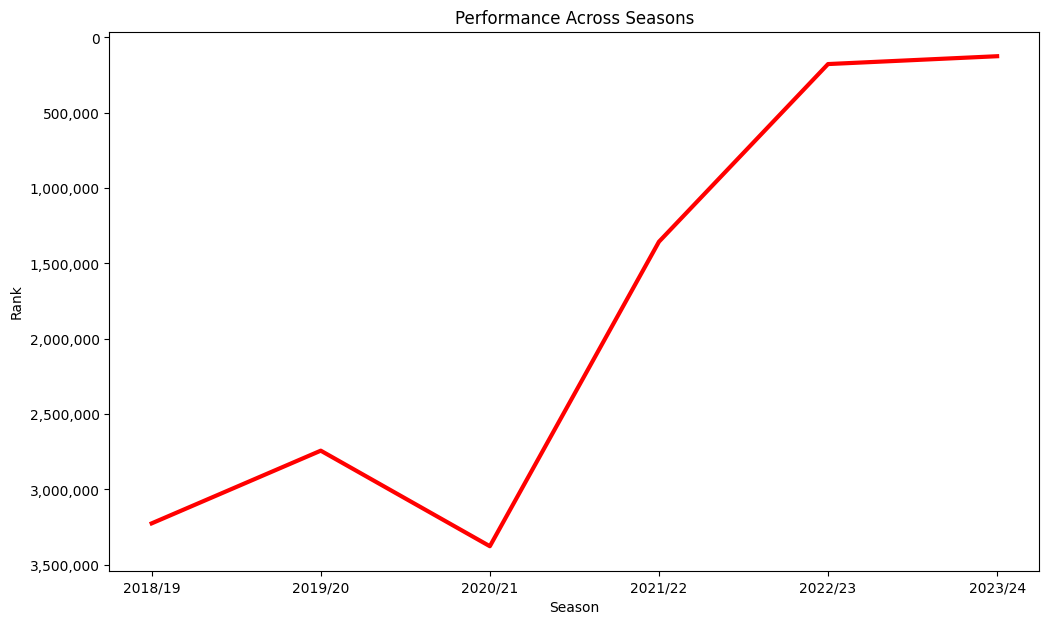

In [10]:
### plot prev ssn performances
### filter to 6 seasons
prev_6_ssn_ranks = prev_ssn_ranks.tail(6)


plt.figure(figsize=(12,7))

ax = sns.lineplot(data = prev_6_ssn_ranks,x='season_name',y='rank',color = 'red',linewidth = 3)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: '{:,.0f}'.format(x)))
### invert y axis
ax.invert_yaxis()




### add labels
ax.set_title('Performance Across Seasons')
ax.set_ylabel('Rank')
ax.set_xlabel('Season')


In [11]:
### write a function that inputs manager id and outputs GW points for entire season alongside chips 

def get_gw_points(manager_id):
    '''get a manager's past season history'''
    r = requests.get(
        base_url + 'entry/'+ str(manager_id)+'/history/'
    ).json()
    df = pd.json_normalize(r['current'])
    dt = pd.json_normalize(r['chips']).rename(columns={'name':'chip_used'})#,'event':'game_week'
    dft = df.merge(dt,on='event', how='left')
    dft['manager_id'] = manager_id
    dft['chip_used'].fillna('none',inplace=True)


    return dft
   

In [12]:
### print a specific manager's points for the most recent season
nenes_ballerz = get_gw_points(5152606)[['event','points','total_points','points_on_bench','chip_used','event_transfers','event_transfers_cost','rank','overall_rank','percentile_rank','bank','value']].reset_index().sort_values(by = 'event',ascending=True)
nenes_ballerz.head()

,index,event,points,total_points,points_on_bench,chip_used,event_transfers,event_transfers_cost,rank,overall_rank,percentile_rank,bank,value
0,0,1,75,75,15,none,0,0,1648468,1648468,NaN,5,1000
1,1,2,49,124,2,none,1,0,3142665,1745184,NaN,0,1002
2,2,3,60,176,7,none,3,8,806267,1258116,NaN,4,1007
3,3,4,84,260,2,none,1,0,1439976,666287,NaN,4,1012
4,4,5,51,311,10,none,0,0,2124361,408068,NaN,4,1014


### Test Hypotheses

#### Rank by Gameweek

In [13]:
### get total managers in the season
total_managers = r['total_players']

pprint(total_managers)#.head()

10905021


In [14]:
### add total managers
nenes_ballerz['total_managers'] = total_managers 

## compute rank to total managers ratio
nenes_ballerz['rank_over_managers'] = nenes_ballerz['overall_rank']/nenes_ballerz['total_managers']

nenes_ballerz.head()

,index,event,points,total_points,points_on_bench,chip_used,event_transfers,event_transfers_cost,rank,overall_rank,percentile_rank,bank,value,total_managers,rank_over_managers
0,0,1,75,75,15,none,0,0,1648468,1648468,NaN,5,1000,10905021,0.151166
1,1,2,49,124,2,none,1,0,3142665,1745184,NaN,0,1002,10905021,0.160035
2,2,3,60,176,7,none,3,8,806267,1258116,NaN,4,1007,10905021,0.115370
3,3,4,84,260,2,none,1,0,1439976,666287,NaN,4,1012,10905021,0.061099
4,4,5,51,311,10,none,0,0,2124361,408068,NaN,4,1014,10905021,0.037420


#### Team rank Over the Game Weeks

Text(0, 0.5, 'Rank')

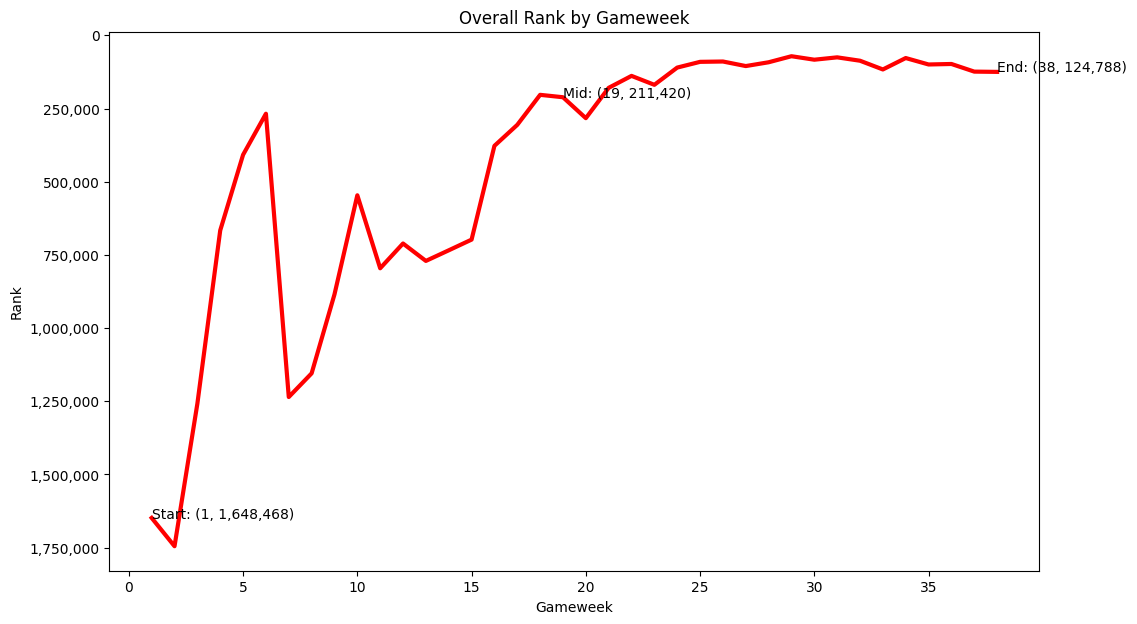

In [15]:
### plot rank by GW 
#rank_by_GW = nenes_ballerz['overall_rank'].value_counts().sort_index(by)

plt.figure(figsize=(12,7))

## invert y axis values
#nenes_ballerz['rank_over_managers_inverted'] = nenes_ballerz['rank_over_managers'].max() - nenes_ballerz['rank_over_managers']

ax = sns.lineplot(data = nenes_ballerz,x='event',y='overall_rank',color = 'red',linewidth = 3)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: '{:,.0f}'.format(x)))

## invert y axis
ax.invert_yaxis()

x = nenes_ballerz['event']
y = nenes_ballerz['overall_rank']

# Add data labels to the start, mid, and end points

plt.annotate(f'Start: ({x.iloc[0]}, {y.iloc[0]:,.0f})', xy=(x.iloc[0], y.iloc[0]), xytext=(x.iloc[0], y.iloc[0] - 50))
plt.annotate(f'Mid: ({x.iloc[len(x) // 2-1]}, {y.iloc[len(y) // 2-1]:,.0f})', xy=(x.iloc[len(x) // 2-1], y.iloc[len(y) // 2-1]), 
             xytext=(x.iloc[len(x) // 2-1], y.iloc[len(y) // 2-1] - 50)
             )
plt.annotate(f'End: ({x.iloc[-1]}, {y.iloc[-1]:,.0f})', xy=(x.iloc[-1], y.iloc[-1]), xytext=(x.iloc[-1], y.iloc[-1] - 50)
             )


ax.set_title('Overall Rank by Gameweek')
ax.set_xlabel('Gameweek')
ax.set_ylabel('Rank')


In [16]:
### merge gameweek details to managers' team gw performance
nenes_ballerz = pd.merge(left =nenes_ballerz ,right=game_week_details,left_on='event',right_on='id',how='left').rename(columns={'average_entry_score':'average_score'})

### calculate the difference from average
nenes_ballerz['diff_from_avg'] = nenes_ballerz['points'] - nenes_ballerz['average_score'] 
nenes_ballerz.head()

,index,event,points,total_points,points_on_bench,chip_used,event_transfers,event_transfers_cost,rank,overall_rank,...,value,total_managers,rank_over_managers,id,name,average_score,highest_score,deadline_time,most_captained,diff_from_avg
0,0,1,75,75,15,none,0,0,1648468,1648468,...,1000,10905021,0.151166,1,Gameweek 1,64,127,2023-08-11 20:08:00,355,11
1,1,2,49,124,2,none,1,0,3142665,1745184,...,1002,10905021,0.160035,2,Gameweek 2,44,120,2023-08-18 20:08:00,355,5
2,2,3,60,176,7,none,3,8,806267,1258116,...,1007,10905021,0.115370,3,Gameweek 3,44,128,2023-08-25 20:08:00,355,16
3,3,4,84,260,2,none,1,0,1439976,666287,...,1012,10905021,0.061099,4,Gameweek 4,72,148,2023-09-01 20:09:00,355,12
4,4,5,51,311,10,none,0,0,2124361,408068,...,1014,10905021,0.037420,5,Gameweek 5,44,102,2023-09-16 13:09:00,355,7


#### Breakout Chips Usage

In [17]:

### analyze chips and influence on points relative to average points
chips_usage = nenes_ballerz[nenes_ballerz['chip_used']!='none']
cols = ['name','points','average_score','diff_from_avg','chip_used']
chips_usage = chips_usage[cols]
chips_usage

,name,points,average_score,diff_from_avg,chip_used
9,Gameweek 10,79,66,13,wildcard
24,Gameweek 25,91,73,18,3xc
28,Gameweek 29,26,12,14,freehit
33,Gameweek 34,122,76,46,bboost
36,Gameweek 37,113,83,30,wildcard


In [18]:
# pull stats on chips usage
chips_usage.describe()

,points,average_score,diff_from_avg
count,5.000000,5.000000,5.000000
mean,86.200000,62.000000,24.200000
std,37.745198,28.609439,13.935566
min,26.000000,12.000000,13.000000
25%,79.000000,66.000000,14.000000
50%,91.000000,73.000000,18.000000
75%,113.000000,76.000000,30.000000
max,122.000000,83.000000,46.000000


#### Breakout Points on Bench

In [19]:
### break out points on bench
nenes_ballerz['points_on_bench'].describe()

count    38.000000
mean      8.447368
std       6.599334
min       0.000000
25%       3.250000
50%       7.500000
75%      11.750000
max      31.000000
Name: points_on_bench, dtype: float64

In [20]:
### pull out the gameweeks with min and max points on bench
### max points on bench
max_points_on_bench = nenes_ballerz['points_on_bench'].max()  
points_on_bench_gw_mx = nenes_ballerz.loc[nenes_ballerz['points_on_bench']==max_points_on_bench,['points','average_score','points_on_bench','name']]

points_on_bench_gw_mx

,points,average_score,points_on_bench,name
22,68,57,31,Gameweek 23


In [21]:
points_on_bench_gw_mx['points_left_over_gannered'] = points_on_bench_gw_mx['points_on_bench']/points_on_bench_gw_mx['points']
points_on_bench_gw_mx

,points,average_score,points_on_bench,name,points_left_over_gannered
22,68,57,31,Gameweek 23,0.455882


In [22]:
### show key cols alongside points on bench
columns_for_on_bench = ['name','points','points_on_bench']

nenes_ballerz[columns_for_on_bench].reset_index().sort_values(by = 'points_on_bench', ascending=False).head()

,index,name,points,points_on_bench
22,22,Gameweek 23,68,31
27,27,Gameweek 28,61,21
13,13,Gameweek 14,61,20
17,17,Gameweek 18,57,16
36,36,Gameweek 37,113,16


In [23]:
### min points on bench
min_points_on_bench = nenes_ballerz['points_on_bench'].min()
points_on_bench_gw_mn = nenes_ballerz.loc[nenes_ballerz['points_on_bench']==min_points_on_bench,['points','average_score','points_on_bench','name']]
points_on_bench_gw_mn

,points,average_score,points_on_bench,name
16,65,44,0,Gameweek 17
33,122,76,0,Gameweek 34
34,66,52,0,Gameweek 35


#### Breakdown Transfers

In [24]:
### transfers analysis
transfer_deets = ['name','points','diff_from_avg','bank','event_transfers','event_transfers_cost']


transfers_made = nenes_ballerz[transfer_deets]
transfers_made = transfers_made.loc[transfers_made['bank']>0]
transfers_made.reset_index().sort_values(by='diff_from_avg',ascending=True).head(10)


,index,name,points,diff_from_avg,bank,event_transfers,event_transfers_cost
7,10,Gameweek 11,22,-10,4,0,0
9,12,Gameweek 13,46,0,7,1,0
11,14,Gameweek 15,37,2,7,1,0
15,18,Gameweek 19,41,3,41,0,0
28,31,Gameweek 32,59,3,15,0,0
29,32,Gameweek 33,63,5,34,2,0
3,4,Gameweek 5,51,7,4,0,0
10,13,Gameweek 14,61,7,11,2,0
26,29,Gameweek 30,56,9,12,1,0
22,25,Gameweek 26,56,10,18,1,0


In [25]:
### write a function that inputs manager id and outputs GW transfers

def get_gw_transfers(manager_id):
    '''get a manager's transfers'''
    r = requests.get(
        base_url + 'entry/'+str(manager_id)+'/transfers/').json()
    df = pd.json_normalize(r)
    ### convert to date time from string
    df['time']= pd.to_datetime(df['time'])#.dt.tz_localize('UTC')


    return df

In [26]:
### pull transfers made
transfers = get_gw_transfers(5152606)
transfers.head()

,element_in,element_in_cost,element_out,element_out_cost,entry,event,time
0,232,50,415,83,5152606,38,2024-05-18 05:37:46.202923+00:00
1,308,134,19,86,5152606,38,2024-05-18 05:37:46.197304+00:00
2,511,51,178,39,5152606,37,2024-05-10 05:13:12.132588+00:00
3,616,51,377,51,5152606,37,2024-05-10 04:52:00.389086+00:00
4,412,64,226,60,5152606,37,2024-05-10 04:52:00.388637+00:00


In [27]:
### convert to EAT
transfers['time'] =  transfers['time'].dt.tz_convert('Africa/Nairobi')

### format
transfers['time'] = transfers['time'].dt.strftime('%Y-%m-%d %H:%M:%S')

transfers.head()

,element_in,element_in_cost,element_out,element_out_cost,entry,event,time
0,232,50,415,83,5152606,38,2024-05-18 08:37:46
1,308,134,19,86,5152606,38,2024-05-18 08:37:46
2,511,51,178,39,5152606,37,2024-05-10 08:13:12
3,616,51,377,51,5152606,37,2024-05-10 07:52:00
4,412,64,226,60,5152606,37,2024-05-10 07:52:00


In [28]:
### calculate number of transfers, last time of update per gameweek
transfers_per_gw = transfers.groupby(['event']).agg({'time':'max','element_in':'count'}).reset_index().sort_values(by = 'event',ascending=True)
transfers_per_gw.head()

,event,time,element_in
0,2,2023-08-17 23:20:52,1
1,3,2023-08-25 13:16:44,3
2,4,2023-08-30 13:45:31,1
3,6,2023-09-21 15:57:23,2
4,8,2023-10-07 07:40:03,4


In [29]:
### add transfer details to main dataset
nenes_ballerz = pd.merge(left=nenes_ballerz,right=transfers_per_gw,left_on='event',right_on='event',how='left')
nenes_ballerz_transfers = nenes_ballerz.loc[:,['name','event_transfers','deadline_time','time']]
nenes_ballerz_transfers.head()

,name,event_transfers,deadline_time,time
0,Gameweek 1,0,2023-08-11 20:08:00,NaN
1,Gameweek 2,1,2023-08-18 20:08:00,2023-08-17 23:20:52
2,Gameweek 3,3,2023-08-25 20:08:00,2023-08-25 13:16:44
3,Gameweek 4,1,2023-09-01 20:09:00,2023-08-30 13:45:31
4,Gameweek 5,0,2023-09-16 13:09:00,NaN


In [30]:
### how many gamweeks did Nene's ballerz not make a transfer
nenes_ballerz_transfers['event_transfers'].value_counts()

1    13
2    12
0    11
3     1
4     1
Name: event_transfers, dtype: int64

In [31]:
### GWs with no transfers
no_transfers_gw = nenes_ballerz.loc[nenes_ballerz['event_transfers']==0,['name','points','highest_score','average_score']]
no_transfers_gw
                                    

,name,points,highest_score,average_score
0,Gameweek 1,75,127,64
4,Gameweek 5,51,102,44
6,Gameweek 7,30,156,49
9,Gameweek 10,79,134,66
10,Gameweek 11,22,107,32
18,Gameweek 19,41,105,38
21,Gameweek 22,65,128,48
27,Gameweek 28,61,122,44
28,Gameweek 29,26,78,12
31,Gameweek 32,59,125,56


In [32]:
### how many transfers were made on the deadline day

In [33]:
### study transfers made/not made and influence on GW points


#### Team Points by Highest Score

Text(0.5, 0, 'Game Week')

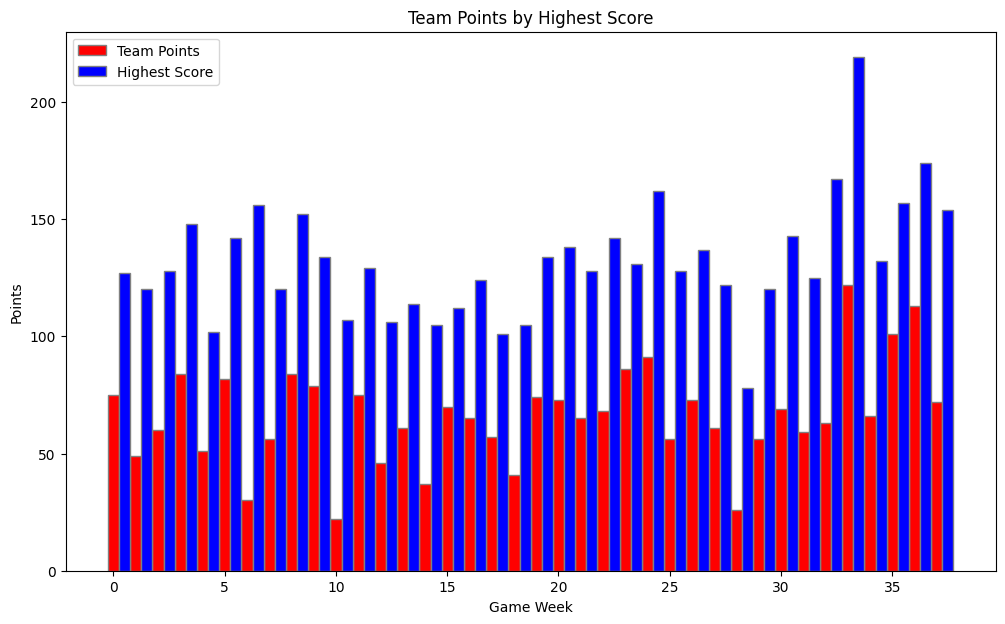

In [34]:
### plot team score vs highest score

## set bar width
bar_width = 0.50

## set positions of the bar
r1 = range(len(nenes_ballerz['points']))
r2 = [x + bar_width for x in r1]

## create the plot
plt.figure(figsize=(12,7))

## make the bar plot
plt.bar(r1, nenes_ballerz['points'],color = 'red',width=bar_width,edgecolor = 'grey',label = 'Team Points')
plt.bar(r2,nenes_ballerz['highest_score'],color = 'blue',width=bar_width,edgecolor = 'grey',label = 'Highest Score')

plt.legend()
plt.title('Team Points by Highest Score')
plt.ylabel('Points')
plt.xlabel('Game Week')


In [35]:
### pull out max diff from highest score
nenes_ballerz['diff_from_highest'] = nenes_ballerz['highest_score'] - nenes_ballerz['points']


nenes_ballerz.loc[:,['name','points','highest_score','diff_from_highest','diff_from_avg']].sort_values(by = 'diff_from_highest' ,ascending=False).head()

,name,points,highest_score,diff_from_highest,diff_from_avg
6,Gameweek 7,30,156,126,-19
32,Gameweek 33,63,167,104,5
33,Gameweek 34,122,219,97,46
10,Gameweek 11,22,107,85,-10
37,Gameweek 38,72,154,82,20


In [36]:
### pull some stats on the differences
nenes_ballerz['diff_from_highest'].describe()

count     38.000000
mean      65.921053
std       16.222076
min       42.000000
25%       56.750000
50%       64.000000
75%       70.250000
max      126.000000
Name: diff_from_highest, dtype: float64

#### Points by Game Week Average

In [37]:
### difference from average stats
nenes_ballerz['diff_from_avg'].describe()

count    38.000000
mean     13.552632
std      11.497820
min     -19.000000
25%       7.500000
50%      13.500000
75%      19.500000
max      46.000000
Name: diff_from_avg, dtype: float64

In [38]:
### pull points for min and max difference gameweeks
### pull points for worst gameweek vs average score

max_negative_dev = nenes_ballerz['diff_from_avg'].min()
points_for_gw = nenes_ballerz.loc[nenes_ballerz['diff_from_avg'] == max_negative_dev, ['points', 'average_score','name']]

points_for_gw


,points,average_score,name
6,30,49,Gameweek 7


In [39]:
### pull points for best gameweek vs average score
max_positive_dev = nenes_ballerz['diff_from_avg'].max()
points_for_gw = nenes_ballerz.loc[nenes_ballerz['diff_from_avg']==max_positive_dev,['points', 'average_score','name']]

points_for_gw

,points,average_score,name
33,122,76,Gameweek 34


In [40]:
nenes_ballerz['chip_used'].value_counts()

none        33
wildcard     2
3xc          1
freehit      1
bboost       1
Name: chip_used, dtype: int64

Text(0, 0.5, 'Points')

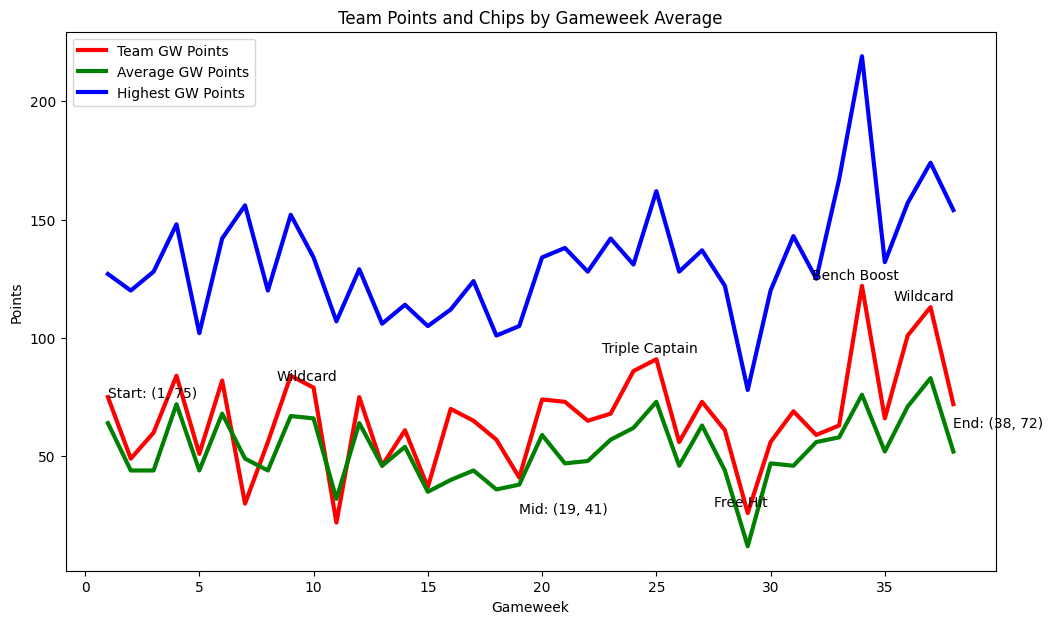

In [41]:
### Plot team points by gameweek average
plt.figure(figsize=(12,7))

ax = sns.lineplot(data=nenes_ballerz,x='event' ,y='points',color = 'red',linewidth= 3,label = 'Team GW Points')
ax = sns.lineplot(data=nenes_ballerz,x='event',y='average_score',color = 'green',linewidth = 3,label = 'Average GW Points')
ax = sns.lineplot(data=nenes_ballerz,x='event',y='highest_score',color = 'blue',linewidth = 3,label = 'Highest GW Points')


# Add data labels to the start, mid, and end points
x = nenes_ballerz['event']
y = nenes_ballerz['points']

plt.annotate(f'Start: ({x.iloc[0]}, {y.iloc[0]:,.0f})', xy=(x.iloc[0], y.iloc[0]), xytext=(x.iloc[0], y.iloc[0] + 0))
plt.annotate(f'Mid: ({x.iloc[len(x) // 2-1]}, {y.iloc[len(y) // 2-1]:,.0f})', xy=(x.iloc[len(x) // 2-1], y.iloc[len(y) // 2-1]), 
             xytext=(x.iloc[len(x) // 2-1], y.iloc[len(y) // 2-1] - 15)
             )
plt.annotate(f'End: ({x.iloc[-1]}, {y.iloc[-1]:,.0f})', xy=(x.iloc[-1], y.iloc[-1]), xytext=(x.iloc[-1], y.iloc[-1] - 10)
             )

### annotate chip usage
chip_events = {'Wildcard':'wildcard','Triple Captain':'3xc','Free Hit':'freehit', 'Bench Boost':'bboost'}
for chip_name, chip_event in chip_events.items():
    chip_event_data = nenes_ballerz[nenes_ballerz['chip_used']== chip_event]
    for i, row in chip_event_data.iterrows():
        ax.annotate(chip_name,(row['event'],row['points']),textcoords="offset points", xytext=(-5,5),ha= 'center')


plt.legend()
ax.set_title('Team Points and Chips by Gameweek Average')
ax.set_xlabel('Gameweek')
ax.set_ylabel('Points')


### Findings

- To a great extent, Nene's Ballerz mapped a slightly better than average performance, with Gameweek 34 the best performing with a gain of 46 points from the average. Gameweek 7 was the worst performed with a deviance of -19 points off the average and also had the biggest difference from the highest scorer.
- The chips usage was beneficial in gunning points from the average, generating an average of 24 positive points.
- On average Nene's Ballerz left 8 points on the bench, at game week 23 leaving 31 possible points, which was almost half (46%) the points achieved that gameweek.  

- [x] Squad selection offers an opportunity for improvement, with points left on the bench denting the points accumulated in the respective game week as well as the ultimate season points. Chips usage as well as Captain picks (with a 2*multiplier) could have been used more tactfully, but a detailed analysis of the latter is currently out of the scope of this notebook. Similarly, the analysis of league competitors, (best performing global managers as well as in mini-leagues) will be covered in a separate report. While the inclusion of these supporting data points would have offered a wholesome view, it is also wise to consider that all the above results are subject to survivorship bias (Nassim Taleb-Fooled by Randomness). In a different set of circumstances, the above decisions and inputs in my game week events would have yielded totally differently outcomes. Nevertheless, given that the valid game week trend observations, there's a high chance- ceteris paribus, that better decisions in squad selection would have resulted in more points and eventually a better overall rank.  